## Navier–Stokes 方程与弱形式

不可压缩 Navier–Stokes 方程是描述粘性不可压流体随时间演化的基本模型，广泛应用于工程、物理和生物流体等领域。在本节中，我们将介绍其强形式与弱形式，并为后续数值离散构建理论基础。

### 1. 方程组

考虑在时空区域 $Q := \Omega \times (0,T)$ 上的不可压缩 Navier–Stokes 方程，其组成如下：

1. **动量方程（Newton 第二定律）**：
   $$
   \rho \frac{\partial \mathbf{u}}{\partial t} + \rho (\mathbf{u} \cdot \nabla) \mathbf{u} = -\nabla p + \mu \Delta \mathbf{u} + \mathbf{f},
   $$

2. **质量守恒方程（不可压缩性约束）**：
   $$
   \nabla \cdot \mathbf{u} = 0.
   $$

其中变量含义为：

- $\mathbf{u} : \Omega \to \mathbb{R}^d$ 为速度场；
- $p : \Omega \to \mathbb{R}$ 为压力场；
- $\rho$ 为常数密度；
- $\mu$ 为动力黏性系数；
- $\mathbf{f}$ 为体积力源项；
- 通常 $\Omega \subset \mathbb{R}^d$，$d=2$ 或 $3$。

---

### 2. 初始与边界条件

为使问题适定，需要规定以下边值条件与初始条件：

- **速度 Dirichlet 边界条件**：
  $$
  \mathbf{u} = \mathbf{g} \quad \text{on } \partial \Omega_D \times (0,T),
  $$

- **Neumann 自然边界条件**（对应出口或自由边界）：
  $$
  \boldsymbol{\sigma}(\mathbf{u}, p) \cdot \mathbf{n} = \mathbf{h} \quad \text{on } \partial \Omega_N \times (0,T),
  $$
  其中
  $$
  \boldsymbol{\sigma}(\mathbf{u}, p) := -p \mathbf{I} + 2\mu \varepsilon(\mathbf{u}), \quad
  \varepsilon(\mathbf{u}) := \frac{1}{2}(\nabla \mathbf{u} + \nabla \mathbf{u}^T).
  $$

- **初始条件**：
  $$
  \mathbf{u}(\mathbf{x}, 0) = \mathbf{u}_0(\mathbf{x}) \quad \text{in } \Omega.
  $$

---

### 3. 弱形式推导

为进行有限元离散，我们对方程组乘以测试函数，并在空间上积分，得到如下弱形式。

设：

- $\mathbf{V} := \{ \mathbf{v} \in [H^1(\Omega)]^d \mid \mathbf{v} = \mathbf{0} \text{ on } \partial \Omega_D \}$；
- $Q := L^2(\Omega)$。

则寻找 $(\mathbf{u}, p) : [0, T] \to \mathbf{V} \times Q$，使得对于任意 $(\mathbf{v}, q) \in \mathbf{V} \times Q$，有：

$$
\begin{aligned}
\int_{\Omega} \partial_t \mathbf{u} \cdot \mathbf{v} \, dx
+ \int_{\Omega} \nu \nabla \mathbf{u} : \nabla \mathbf{v} \, dx
+ \int_{\Omega} (\mathbf{u} \cdot \nabla)\mathbf{u} \cdot \mathbf{v} \, dx
- \int_{\Omega} p \nabla \cdot \mathbf{v} \, dx
&= \int_{\Omega} \mathbf{f} \cdot \mathbf{v} \, dx, \\
- \int_{\Omega} q \, \nabla \cdot \mathbf{u} \, dx &= 0.
\end{aligned}
$$

附带初始条件：

$$
\mathbf{u}(x, 0) = \mathbf{u}_0(x) \quad \text{in } \Omega.
$$


## 1. 必要准备

### 1.1 导入必要库

In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *
from netgen.webgui import Draw as DrawGeo
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

### 1.2 必要参数设置

In [2]:
nu = 0.001
dt = 0.001
k = 3
tend = 1
t = 0; cnt = 0

## 2. 几何建模与网格生成（Geometry and Mesh Generation）

为研究不可压缩纳维-斯托克斯（Navier–Stokes）方程在典型二维内部流动结构中的数值行为，本文采用有限元软件 **NGSolve** 构建了一个包含圆柱障碍物的二维矩形通道几何模型。该几何结构为经典的 **流经圆柱的流体问题（flow around a cylinder）** 提供了基础测试平台。

### 2.1 几何定义

本研究所用的二维流动区域由以下部分构成：

- 一个长为 $2.2$、高为 $0.41$ 的矩形通道；
- 通道内部嵌有一个位于坐标点 $(0.2, 0.2)$、半径为 $0.05$ 的圆柱障碍物。

上述几何通过 `Netgen/NGSolve` 的 `OCCGeometry` 模块构造如下：

In [3]:
shape = Rectangle(2.2,0.41).Circle(0.2,0.2,0.05).Reverse().Face()

### 2.2 边界条件区域标记

为设定恰当的边界条件，需为几何边界赋予明确的名称，以便在后续弱形式构造与有限元空间定义中调用。具体边界标记如下：

In [4]:
# 为几何边界命名，用于后续施加边界条件
shape.edges.name = "cyl"             # 内部圆柱边界
shape.edges.Min(X).name = "inlet"    # 左侧入口边界
shape.edges.Max(X).name = "outlet"   # 右侧出口边界
shape.edges.Min(Y).name = "wall"     # 下壁面
shape.edges.Max(Y).name = "wall"     # 上壁面

### 2.3 网格生成

构建完成的几何体通过 OCC（OpenCascade） 内核生成有限元网格。为平衡计算效率与精度，本文将最大单元尺寸 `maxh` 设置为 $1/8$，并使用三阶曲线单元对边界进行几何拟合。

In [5]:
mesh = Mesh(OCCGeometry(shape, dim=2).GenerateMesh(maxh=1/8)).Curve(3) 
# `GenerateMesh(maxh=1/8)` 表示使用最大网格尺度为 $0.125$；
# `.Curve(3)` 将几何边界提升为三阶拟合，以更准确地表示圆柱边界。

绘制图像（可选）

In [6]:
DrawGeo(shape);
Draw(mesh);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': 3…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

## 3. 有限元空间，边界条件与初值条件设定（Finite Element Spaces, Boundary Conditions and Initial Condition）

为求解不可压缩 Navier–Stokes 方程，我们采用混合有限元方法构造速度和压力的函数空间。速度采用二阶向量型连续有限元（VectorH1），压力采用一阶标量连续有限元（H1），从而形成经典的 P2-P1 速度-压力配对，满足稳定性条件。

### 3.1 有限元空间定义

In [7]:
V = VectorH1(mesh, order=k, dirichlet="wall|cyl|inlet")  # 设置速度空间，指定 Dirichlet 边界为壁面、圆柱和入口
Q = H1(mesh, order=k-1)                                  # 压力空间为标量一阶 H1 空间
X = V * Q                                                # 构造混合有限元空间（速度 × 压力）

### 3.2 解函数与边界条件设定

在耦合空间 `X` 上定义解函数 `gfu` ，其包含速度和压力两个分量，分别命名以方便调用和边界条件施加。

In [8]:
gfu = GridFunction(X)
velocity, pressure = gfu.components

为解向量定义非齐次Dirichlet边界条件
在入口处施加典型的层流抛物线速度分布，其 $x$ 方向速度分布为：

$$
u_{\text{in}}(y) = \left( \frac{6}{0.41^2} y(0.41 - y), \; 0 \right)
$$

该分布在上下壁面速度为零，中部最大，符合管道流理论。

In [9]:
uin = CoefficientFunction((1.5 * 4 * y * (0.41 - y) / (0.41 * 0.41), 0))  # 抛物线型入口速度分布
velocity.Set(uin, definedon=mesh.Boundaries("inlet"))                    # 在 inlet 边界上设置速度 Dirichlet 条件

绘制图像（可选）

In [11]:
Draw(velocity);
Draw(pressure);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

### 3.3 Stokes 初始解的构造

为提供稳定的初值，用稳态 Stokes 问题构造一个速度–压力场作为初始化。首先定义试验函数和检验函数，并构建双线性形式：

In [12]:
(u, p), (v, q) = X.TnT()                                                  # 获取试验函数与检验函数
a = BilinearForm(X)                                                      # 定义双线性形式
stokes = (nu * InnerProduct(grad(u), grad(v)) - div(u) * q - div(v) * p) * dx  # Stokes 双线性项
a += stokes                                                              # 加入双线性形式中
a.Assemble();                                                             # 组装刚度矩阵
f = LinearForm(X)         # 定义右端项
f.Assemble()              # 组装右端项

最后求解 Stokes 系统，并将解更新至 'gfu.vec' 以作为后续 Navier–Stokes 求解的初始值：

In [13]:
res = f.vec - a.mat * gfu.vec                  # 计算初始残差
inv_stokes = a.mat.Inverse(X.FreeDofs())       # 构建在自由自由度上的逆算子
gfu.vec.data += inv_stokes * res               # 更新解函数为稳态 Stokes 解

In [14]:
drag_x_test = GridFunction(X)
drag_x_test.components[0].Set(CoefficientFunction((-20.0,0)), definedon=mesh.Boundaries("cyl"))
drag_y_test = GridFunction(X)
drag_y_test.components[0].Set(CoefficientFunction((0,-20.0)), definedon=mesh.Boundaries("cyl"))

绘制图像（可选）

In [15]:
Draw(velocity);
Draw(pressure);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

### 4 时间离散与对流项处理

不可压缩 Navier–Stokes 方程的完整形式为：

$$
\begin{aligned}
\partial_t \mathbf{u} + (\mathbf{u} \cdot \nabla)\mathbf{u} - \nu \Delta \mathbf{u} + \nabla p &= \mathbf{f} \quad \text{in } \Omega, \\
\operatorname{div}(\mathbf{u}) &= 0 \quad \text{in } \Omega.
\end{aligned}
$$

### 4.1 一般形式

我们采用 **隐式–显式欧拉时间离散（IMEX Euler）** 策略，对时间导数项使用向后差分，对扩散项隐式处理，对对流项显式处理。

设当前时间为 $t^n$，时间步长为 $\Delta t$，已知速度解 $\mathbf{u}^n$，则时间离散形式为：

$(\mathbf{u}^{n+1},p^{n+1}) \in X = \mathbf{V} \times Q$, s.t. for all $(\mathbf{v},q) \in X = \mathbf{V} \times Q$

\begin{align}
\underbrace{m(\mathbf{u}^{n+1},\mathbf{v}) + \Delta t ~\cdot~a((\mathbf{u}^{n+1},p^{n+1}),(\mathbf{v},q))}_{ \to M^\ast} ~=~m(\mathbf{u}^{n},\mathbf{v}) - \Delta t ~\cdot~c(\mathbf{u}^{n}; \mathbf{u}^{n},\mathbf{v}) 
\end{align}

### 非齐次 Dirichlet 边界条件的处理

上节推导的离散系统默认速度满足 $\mathbf{u} = 0$ 于 $\partial \Omega_D$（即齐次 Dirichlet 条件）。在实际问题中，尤其是通道流、绕流问题中，我们往往在入口边界施加给定的速度剖面（如抛物线型分布）：

$$
\mathbf{u} = \mathbf{g} \neq 0 \quad \text{on } \partial \Omega_D.
$$

为处理这类**非齐次边界条件**，常用的方法是**变量替换法（lifting method）**，即将问题的解写为：

$$
\mathbf{u}^{n+1} = \mathbf{u}_h^{n+1} + \tilde{\mathbf{g}},
$$

其中：

- $\mathbf{u}_h^{n+1} \in \mathbf{V}_0$，满足齐次边界条件，即 $\mathbf{u}_h^{n+1} = 0$ on $\partial \Omega_D$；
- $\tilde{\mathbf{g}}$ 是某个固定向量场，满足边界条件 $\tilde{\mathbf{g}} = \mathbf{g}$ on $\partial \Omega_D$，在内部可以任意延拓。

将 $\mathbf{u}^{n+1}$ 代入离散系统中，并将其分离为：

$$
\begin{pmatrix}
	K & Q \\
	Q^T & 0
\end{pmatrix}
\begin{pmatrix}
	\mathbf{u}_h^{n+1} \\
	\mathbf{p}^{n+1}
\end{pmatrix}
=
\begin{pmatrix}
	\mathrm{RHS}^{(i)} - K \tilde{\mathbf{g}} \\
	- Q^T \tilde{\mathbf{g}}
\end{pmatrix}.
$$

我们看到，**非齐次边界条件的影响表现为右端项的修正**，且不改变系统矩阵本身的结构。这种处理方法有两个优点：

- 不需修改原有刚度矩阵装配过程；
- 保证数值求解仅在自由度上进行，边界值通过 $\tilde{\mathbf{g}}$ 注入解中。

在实现中，$\tilde{\mathbf{g}}$ 通常通过如下方式构造：

- 在边界上插值速度剖面 $\mathbf{g}$；
- 在内部扩展为零或任意连续向量场；
- 将其作为 `GridFunction` 的“已知值”施加在 Dirichlet 边界上；
- 并将自由节点构成的子系统送入线性求解器。

In [18]:
gfuD = GridFunction(X)
velocityD, pressureD = gfuD.components

velocityD.Set(uin, definedon=mesh.Boundaries("inlet"))

mstar = BilinearForm(X)
mstar += InnerProduct(u,v)*dx + dt*stokes
mstar.Assemble()
inv = mstar.mat.Inverse(X.FreeDofs())

conv = BilinearForm(X, nonassemble = True)
conv += (Grad(u) * u) * v * dx

m = BilinearForm(InnerProduct(u,v)*dx).Assemble()

gfut = GridFunction(gfu.space,multidim=0)
time_vals, drag_x_vals, drag_y_vals = [],[],[]

gfut.AddMultiDimComponent(gfu.vec)
t = 0; cnt = 0
while t < tend-0.5*dt:
    print ("\rt=", t, end="")

    conv.Assemble()
    # print(conv.mat)
    rhs = (m.mat - dt * conv.mat) * gfu.vec - mstar.mat * gfuD.vec
    gfu.vec.data = gfuD.vec + inv * rhs

    t = t + dt; cnt += 1
    
    # res = (a.mat + conv.mat) * gfu.vec
    # drag_x_vals.append(InnerProduct(res, drag_x_test.vec) )
    # drag_y_vals.append(InnerProduct(res, drag_y_test.vec) )
    # time_vals.append(t)
    
    if cnt % 100 == 0:
        gfut.AddMultiDimComponent(gfu.vec)

t= 0.999000000000000876

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

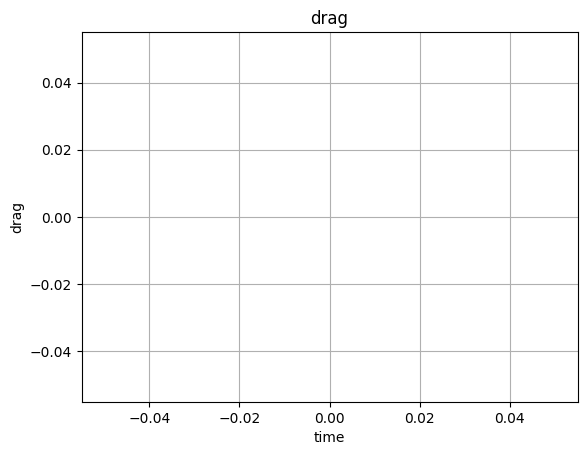

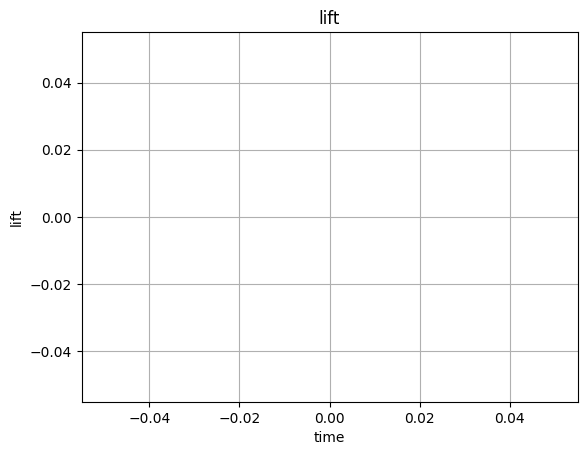

In [19]:
Draw (gfut.components[0], mesh, interpolate_multidim=True, animate=True,
      min=0, max=1.9, autoscale=False, vectors = True)
Draw (gfut.components[1], mesh, interpolate_multidim=True, animate=True,
      min=-0.5, max=1, autoscale=False)

# Plot drag force over time
plt.plot(time_vals, drag_x_vals)
plt.xlabel('time'); plt.ylabel('drag'); plt.title('drag'); plt.grid(True)
plt.show()
# Plot lift force over time
plt.plot(time_vals, drag_y_vals)
plt.xlabel('time'); plt.ylabel('lift'); plt.title('lift'); plt.grid(True)
plt.show()

### 4.2 增量形式

在增量格式中，如采用显式对流–隐式扩散结构（参考 Section~\ref{subsec:bdf1-assembly} 的增量推进格式），速度更新形式为：

$$
\mathbf{u}^{n+1} = \mathbf{u}^{n} + \delta\mathbf{u}^{n+1},
$$

其中 $\delta \mathbf{u}^{n+1}$ 为当前步的速度增量。此时，边界条件 $\mathbf{u}^{n+1} = \mathbf{g}$ 被改写为：

$$
\delta \mathbf{u}^{n+1} = \mathbf{g} - \mathbf{u}^{n} \quad \text{on } \partial\Omega_D.
$$

因此，在构造增量形式下的系统时，只需将边界值 $\mathbf{g}$ 替换为 $\mathbf{g} - \mathbf{u}^{n}$，即可保证增量项满足新的 Dirichlet 条件。

数值实现中，一般先构造上一时刻插值 $\mathbf{u}^{n}$，再计算差值：

与全量系统处理方式一致，增量式下 lifting 同样以修正右端项为主，系统矩阵结构不受影响。

该策略不仅适用于 Navier–Stokes，也适用于带非齐次边界条件的任意双线性时间推进系统。

In [27]:
mstar = BilinearForm(X)
mstar += InnerProduct(u,v)*dx + dt*stokes
mstar.Assemble()
inv = mstar.mat.Inverse(X.FreeDofs())

conv = BilinearForm(X, nonassemble = True)
conv += (Grad(u) * u) * v * dx

gfut = GridFunction(gfu.space,multidim=0)
time_vals, drag_x_vals, drag_y_vals = [],[],[]

gfut.AddMultiDimComponent(gfu.vec)
t = 0; cnt = 0
while t < tend-0.5*dt:
    print ("\rt=", t, end="")

    conv.Assemble()
    # print(conv.mat)
    res = (a.mat + conv.mat)* gfu.vec
    gfu.vec.data -= dt * inv * res

    t = t + dt; cnt += 1
    
    res = (a.mat + conv.mat) * gfu.vec
    drag_x_vals.append(InnerProduct(res, drag_x_test.vec) )
    drag_y_vals.append(InnerProduct(res, drag_y_test.vec) )
    time_vals.append(t)
    
    if cnt % 100 == 0:
        gfut.AddMultiDimComponent(gfu.vec)

t= 24.99900000000757776

动态图及drag-lift图像绘制（可选，若网格较细，动态图绘制可能对电脑造成较大负担）

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

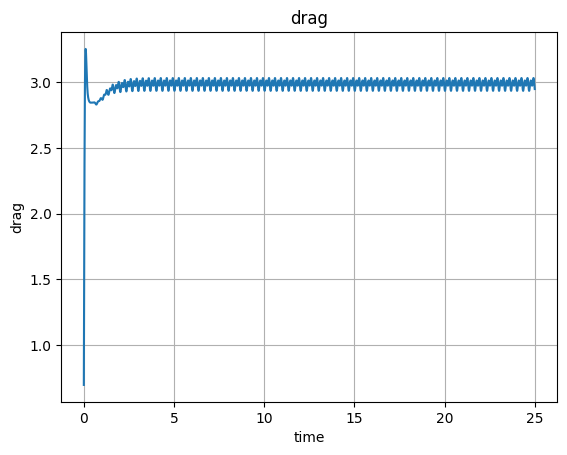

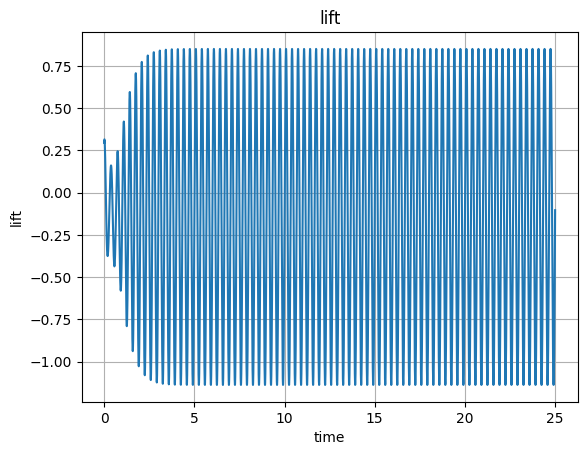

In [28]:
Draw (gfut.components[0], mesh, interpolate_multidim=True, animate=True,
      min=0, max=1.9, autoscale=False, vectors = True)
Draw (gfut.components[1], mesh, interpolate_multidim=True, animate=True,
      min=-0.5, max=1, autoscale=False)

# Plot drag force over time
plt.plot(time_vals, drag_x_vals)
plt.xlabel('time'); plt.ylabel('drag'); plt.title('drag'); plt.grid(True)
plt.show()
# Plot lift force over time
plt.plot(time_vals, drag_y_vals)
plt.xlabel('time'); plt.ylabel('lift'); plt.title('lift'); plt.grid(True)
plt.show()

内容保存（使用paraview进行图像可视化）

## 5. 结果输出与可视化准备（Postprocessing and Visualization Setup）

数值模拟完成后，我们对所得解进行保存与可视化，主要包括两类数据：

- 时间演化过程中**阻力与升力的变化曲线**；
- 多帧速度与压强场的导出，用于可视化（如 Paraview）。

我们将时间、$x$ 方向阻力（drag）与 $y$ 方向升力（lift）保存为 `.npz` 格式，便于后续分析或绘图。

为实现时序数据的三维可视化，我们还将解序列中的速度与压强分别导出为 VTK 文件。由于 NGSolve 是二维计算域，为满足 VTK 三维向量格式要求，需将速度向量补全为 $(u, v, 0)$：

最终，在 `ouputdir/Cylinder_Incremention_BDF1/` 目录下，将生成多个 `.vtu` 文件，供后续使用 Paraview 等工具进行可视化展示和动画制作。

In [ ]:
import numpy as np

np.savez('cylinder_drag_lift.npz', time=time_vals, drag=drag_x_vals, lift=drag_y_vals)

import os

outdir = r".\ouputdir\Cylinder_Incremention_BDF1"
os.makedirs(outdir, exist_ok=True)  # 自动创建目录
file_path = os.path.join(outdir, "1000_8_1000")
vel_cf = CoefficientFunction((
    gfu.components[0][0],
    gfu.components[0][1],
    0.0  # 补上 Z 分量，使其为 3D vector
))
pres_cf = gfu.components[1]

vtkout = VTKOutput(
    mesh,
    coefs = [vel_cf, pres_cf],
    names = ["velocity", "pressure"],
    filename = file_path,
    subdivision = 2
)

nframes = len(gfut.vecs)  # 多帧数量

for i in range(nframes):
    # 提取第i帧的解
    gfu.vec.data = gfut.vecs[i]  # 恢复到第i帧
    outname = vtkout.Do(time=i)
print("已写出：", outname)